In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer as tbwToken
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from IPython.core import display
from sklearn.metrics import f1_score
import string
import numpy as np
import pandas as pd
import seaborn as sns

* Using word2vec we can find the cosine similarity of words 
* Using these word vectors we can use vector averaging to build recommendations using full reviews
* For expediency I've pretrained the model on our dataset. The process is fairly simple using genisms word2vec implementation.
* The model expects a list of sentences, for every sentence in our reviews data set I've stripped puncuation and tokenized the words.
* I settled on using 300 feautres per word, a minimum of 10 words, and a 10 word context window. 
* Here are the functions used

In [335]:
def tokenize(text):
    tbw= tbwToken()
    sentences = text.replace("``","").replace("'","")
    sentences = sent_tokenize(text.encode("ascii","replace"))
    tokens = [tbw.tokenize(s.lower()) for s in sentences]
    tokens = [stripPunc(t) for t in tokens]
    return tokens

def stripPunc(sent):
	tokens = []	
	for t in sent:
		if t not in string.punctuation:
			tokens.append(t)
	return tokens

In [ ]:
sentences = [tokenize(s) for s in reviews[1]]
reducedFat = reduce(lambda x,y: x+y, sentences)

num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model = Word2Vec(reducedFat, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [150]:
model = Word2Vec()
model.load("dataset/binaryFiles/300features_10minwords_102context")

* I trimmed the model
* If the complete memory subsists in memory, you can see fun stuff like this

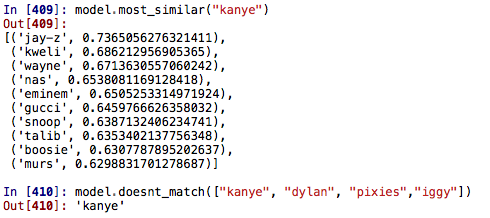

In [24]:
display.Image(filename="savedcharts/word2vecexample.png")

* Let's average the vectors in every review

In [59]:
def lambda_vectoraverage(review,model,num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    modelindex = set(model.index2word)
    #this is the list of words in our word2vec trained model
    sentences = tokenize(review)
    for word in sentences:
        if word not in stopwords.words('english'):
            if word in modelindex:
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec

* After creating the vector averages we can find correlations to get recommendations
* I used a basic pearson correlation function to calculate the closest related reviews

In [127]:
def lambda_corr(vector,corr,df):
    correlations = []
    for index,row in df.iterrows():
        correlation = corr(vector, row.vectorAverage)
        artist = row.artist
        album = row.album
        correlations.append([correlation[0],artist,album]) 
        #scipy's correlation returns a p-value and a correlation statistic, 0 is statistic
    correlations.sort(reverse=True)
    return correlations

In [164]:
Vecs = np.load('dataset/vectorsPitchfork.npy') 
#I saved the vectors seperately in a numpy file
pfdata = pd.read_excel("dataset/FinalPFDataset.xlsx")

* Here is a test example using Kanye

In [165]:
pfdata["vectorAverage"] = Vecs
from scipy.stats import pearsonr
kanyeMask = pfdata["artist"]=="Kanye West"
KanyeAlbums = pfdata[kanyeMask==True]

In [196]:
KanyeAlbums[["BestNewMusic","album","artist","date","reviewScore"]]

BestNewMusic                              album      artist  \
1583       Best new music                  Late Registration  Kanye West   
3348       Best new music                The College Dropout  Kanye West   
6585       Best new music                  The Life of Pablo  Kanye West   
9641       Best new music                             Yeezus  Kanye West   
12598      Best new music  My Beautiful Dark Twisted Fantasy  Kanye West   
13672  Not Best New Music                   VH1 Storytellers  Kanye West   
14918  Not Best New Music                808s and Heartbreak  Kanye West   
16410      Best new music                         Graduation  Kanye West   

                  date  reviewScore  
1583   Sun Aug 28 2005          9.5  
3348   Fri Feb 20 2004          8.2  
6585   Mon Feb 15 2016          9.0  
9641   Tue Jun 18 2013          9.5  
12598  Mon Nov 22 2010         10.0  
13672  Tue Jan 12 2010          4.9  
14918  Tue Dec 02 2008          7.6  
16410  Tue Sep 11 2007          8.7

In [167]:
KanyeCorr = lambda_corr(KanyeAlbums.iloc[2].vectorAverage,pearsonr,pfdata)

In [173]:
KanyeCorr[1:9]

[[0.95418286, u'Drake', u'Nothing Was the Same'],
 [0.95204461, u'Kanye West', u'My Beautiful Dark Twisted Fantasy'],
 [0.95084912, u'T.I.', u'Paperwork'],
 [0.95063049, u'Kendrick Lamar', u'good kid, m.A.A.d city'],
 [0.94984829, u'The Weeknd', u'Beauty Behind the Madness'],
 [0.94961476, u'Kanye West', u'Yeezus'],
 [0.94922298, u'Danny Brown', u'Old'],
 [0.94890183, u'Tyga', u'The Gold Album: 18th Dynasty']]

* These recommendations are rather obvious, but this is most helpful for less known artists
* Here is an example for a band called Wolf Parade
* I filtered to only recommend bands that received an 8 or higher

In [170]:
eightPlus = pfdata["reviewScore"] > 8
wolfparade = pfdata["artist"] == "Wolf Parade"
wfcorr = lambda_corr(pfdata[wolfparade == True].iloc[0].vectorAverage, pearsonr, pfdata[(eightPlus == True)])
pfdata[wolfparade == True]

BestNewMusic                        album       artist  \
1489       Best new music  Apologies to the Queen Mary  Wolf Parade   
1759   Not Best New Music               Wolf Parade EP  Wolf Parade   
13078  Not Best New Music                      Expo 86  Wolf Parade   
15484  Not Best New Music              At Mount Zoomer  Wolf Parade   

                 author             date  \
1489     Brandon Stosuy  Sun Sep 25 2005   
1759     Brandon Stosuy  Thu Jul 07 2005   
13078     Paul Thompson  Tue Jun 29 2010   
15484  Amanda Petrusich  Tue Jun 17 2008   

                                              fullReview genre  reviewScore  \
1489   Considering the amount of pre-release talk sur...  Rock          9.2   
1759   \nA forerunner of the great "Wolf" bandnaming ...  Rock          7.1   
13078  On their third full-length, the indie supergro...  Rock          7.5   
15484  The two distinct, exceptional songwriters in W...  Rock          7.7   

          ARI  CHARACTERS                        ...                          \
1489   23.894        2398                        ...                           
1759   16.874        2299                        ...                           
13078  15.337        2382                        ...                           
15484  14.652        2304                        ...                           

       GUNNING_FOG  SENTENCES    SMOG  SMOG_INDEX  SYLLABLES  WORDS  \
1489          23.6         11  17.540      16.817        795    508   
1759          18.0         15  14.743      14.136        759    502   
13078         17.2         17  14.213      13.627        778    529   
15484         15.2         17  11.670      11.189        750    528   

       Sentiment_Score  Sentence_Count  genreMap  \
1489             -1.00              60         2   
1759              1.01              28         2   
13078             0.77              33         2   
15484            -0.29              22         2   

                                           vectorAverage  
1489   [-0.0241601, -0.319186, 0.321626, 0.0784713, 0...  
1759   [-0.0789229, -0.507792, 0.323683, 0.0870902, 0...  
13078  [-0.126524, -0.410159, 0.32123, 0.167879, 0.03...  
15484  [-0.00422521, -0.339925, 0.310759, 0.0736794, ...  

[4 rows x 24 columns]

In [172]:
wfcorr.sort(reverse=True)
wfcorr[1:9]

[[0.94396746, u'Sunset Rubdown', u'Shut Up I Am Dreaming'],
 [0.93364722, u'Andrew Cedermark', u'Moon Deluxe'],
 [0.93152463, u'Local Natives', u'Gorilla Manor'],
 [0.92846596, u'Local Natives', u'Hummingbird'],
 [0.92174828, u'Sunset Rubdown', u'Dragonslayer'],
 [0.92073423, u'Dirty Projectors', u'Swing Lo Magellan'],
 [0.91899276, u'Chelsea Wolfe', u'Abyss'],
 [0.91734266, u'Handsome Furs', u'Sound Kapital']]

* Spencer Krug the leader singer is also in Sunset Rubdown and the Handsome Furs so these are very good

In [190]:
wfcorr[-20:] #the least likely to be recommended

[[0.56777954, u'Various Artists', u'Hyperdub 10.1'],
 [0.5642488, u'Miles Davis', u'Bitches Brew [Legacy Edition]'],
 [0.56377083,
  u'Miles Davis',
  u'Miles at the Fillmore - Miles Davis 1970: The Bootleg Series Vol. 3'],
 [0.56376195, u'Oneohtrix Point Never', u'R Plus Seven'],
 [0.56257361, u'Babatunde Olatunji', u'Drums of Passion'],
 [0.55642694, u'Patrick Cowley', u'School Daze'],
 [0.5537625,
  u'Africa Express',
  u"Africa Express Presents... Terry Riley's In C Mali"],
 [0.55162525, u'The Delgados', u'The Complete BBC Peel Sessions'],
 [0.55123949, u'Blu', u'NoYork!'],
 [0.54992557, u'Cybotron', u'Enter'],
 [0.54337227, u'Kelela', u'Cut 4 Me'],
 [0.54318136,
  u'Vijay Iyer / Wadada Leo Smith',
  u'A Cosmic Rhythm With Each Stroke'],
 [0.54108244,
  u'Various Artists',
  u'I Heard The Angels Singing: Electrifying Black Gospel'],
 [0.54021144,
  u'K. Leimer',
  u'A Period of Review (Original Recordings: 1975-1983)'],
 [0.53996092,
  u'Various Artists',
  u'I Am The Center: Priva

* Glancing at this list, the recommendation engine thinks that jazz and electronic music listeners probably would not like this band
* Given that the correlation is still rather high, we may want to investigate if this an artifact of the writing style or if we should set a higher limit for our word2vec threshold

## Predicting Best New Music Using Machine Learning

* I will first tokenize and stem the sentences in our data using Count Vectorizer from Sklearn
* Afterward I recombine the data to our structured variables
* Finally I standardize the dataset using the StandardScaler function

In [10]:
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tbw= tbwToken()
    sentences = sent_tokenize(text)
    tokens = reduce(lambda x,y : x+y, [tbw.tokenize(s) for s in sentences])
    tokens = [i.encode("ascii","ignore") for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

encode = {"Best new music":0, "Not Best New Music":1}
#small dictionary to convert our string labels

pfdata = pd.read_excel('/Users/dheepan.ramanan/Documents/PitchforkAnalysis/dataset/trainingData/pfdataTrain.xlsx')
reviews = pfdata.fullReview
vect = CountVectorizer(tokenizer=tokenize, stop_words=stopwords.words('english'),min_df=5,max_features=1000,ngram_range=(1,2))
#transformer = TfidfTransformer( smooth_idf=True, sublinear_tf=False, use_idf=True)
#Using count vectorizer provided better results

xdata = pfdata.drop(["artist","fullReview","date","album","author","genre","reviewScore"],axis=1).reset_index().drop("index",axis=1)
vecBow = vect.fit_transform(reviews)
#vecBowT = transformer.fit_transform(vecBow)

BoW = pd.DataFrame(vecBow.todense(),columns=[vect.get_feature_names()])
xtrain = xdata.join(BoW,rsuffix="_bow").dropna()
ytrain = xtrain["BestNewMusic"].apply(lambda x: encode[x])
xtrain = pd.DataFrame(StandardScaler().fit_transform(xtrain.drop("BestNewMusic",axis=1)),columns=xtrain.columns[1:])

In [11]:
modelStats= {}
classifiers = [LogisticRegression(penalty="l1"), LinearSVC(penalty="l1",dual=False),RandomForestClassifier(),LinearSVC(penalty="l2",dual=False),LogisticRegression(penalty="l2")]
for c in classifiers:
	c.fit(xtrain,ytrain)
	score = cross_val_score(c, xtrain.values, ytrain, cv=5, scoring="f1",n_jobs=1)
	modelStats[c] = score
modelStats

{LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0): array([ 0.95067698,  0.94792671,  0.95167107,  0.95809249,  0.95850324]),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
      verbose=0): array([ 0.95375723,  0.95123709,  0.9569378 ,  0.96040317,  0.96335079]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False): array([ 0.95933014,  0.95770609,  0.95849237,  0.96315789,  0.96699121]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_inte

In [9]:
xtest = pd.read_excel('/Users/dheepan.ramanan/Documents/PitchforkAnalysis/dataset/trainingData/pfdataTest.xlsx').drop(["artist","date","album","author","genre","reviewScore"],axis=1).reset_index().drop("index",axis=1)
testBow = vect.transform(xtest.fullReview)
testBoW = pd.DataFrame(testBow.todense(),columns=[vect.get_feature_names()])
xtestjoin = xtest.join(testBoW,rsuffix="_bow").dropna().drop("fullReview",axis=1)
ytest = xtest["BestNewMusic"].apply(lambda x: encode[x])
xtestjoin = pd.DataFrame(StandardScaler().fit_transform(xtestjoin.drop("BestNewMusic",axis=1)),columns=xtestjoin.columns[1:])

F1Test = {}
for c in classifiers:
	c.fit(xtestjoin,ytest)
	ypred = c.predict(xtestjoin)
	f1= f1_score(ytest,ypred)
	F1Test[c] = f1

NameError: name 'vect' is not defined

In [6]:
F1Test

NameError: name 'F1Test' is not defined

In [7]:
LogReg = LogisticRegression(penalty="l1")

In [8]:
LogReg.fit(xtestjoin,ytest)
ypred = LogReg.predict(xtestjoin)
fscore = f1_score(ytest,ypred)
fscore

NameError: name 'xtestjoin' is not defined

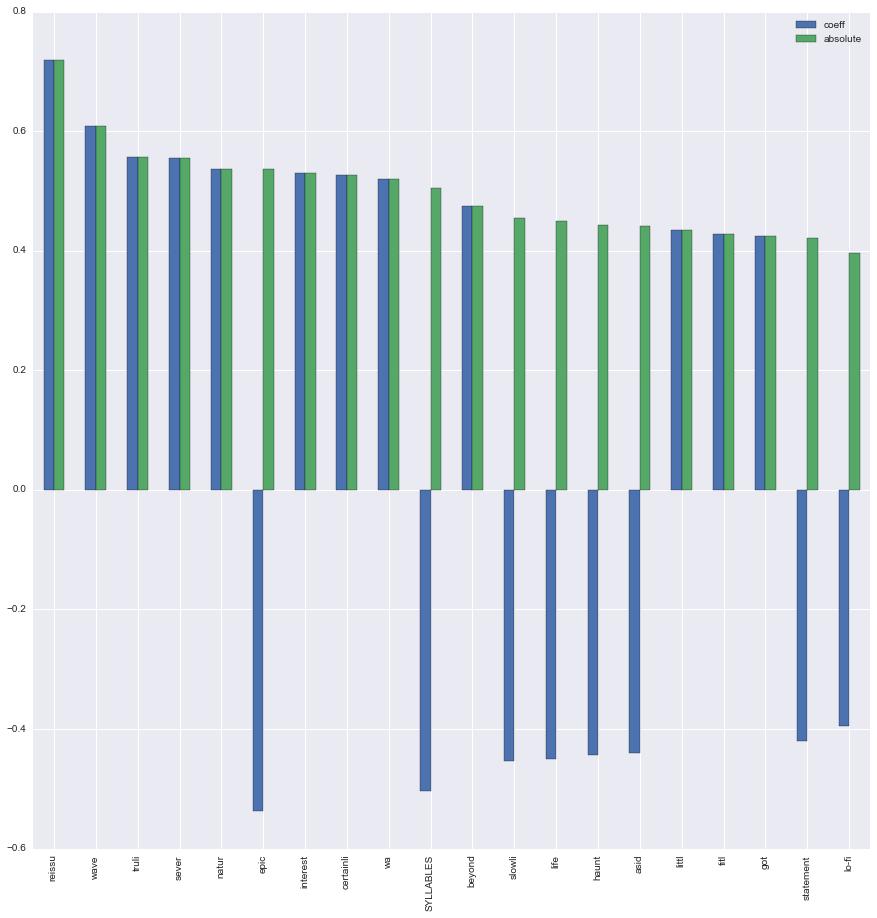

In [18]:
coeff = pd.DataFrame(LogReg.coef_, columns=xtestjoin.columns).T
coeff.columns=["coeff"]
coeff["absolute"] = coeff["coeff"].apply(lambda x : np.absolute(x))
higherAbs = coeff["absolute"] > .05
%matplotlib inline
coeff.sort_values(by="absolute",ascending=False)[:20].plot.bar(figsize=(15,15))

In [443]:
coeff.to_excel("coefficients.xlsx")

In [1]:
from sklearn.feature_selection import RFE

In [3]:
LogReg

NameError: name 'LogReg' is not defined